In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from CMA_obj import CMA_opt
from PEPG_obj import PEPG_opt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from SPSA_obj import SPSA_opt
from Finite_diff_grad import FD_opt
from ADAM_opt import AdamOptimizer
from PSO_obj import PSO_opt
from scipy.interpolate import interp1d
from numpy import asarray
from numpy import savetxt
from NN_utils import *
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import pandas as pd
from torchsummary import summary

np.random.seed(42)
torch.manual_seed(42)


#   Online Training of Neural Networks MNIST

- The NN class helper functions and training loop functions are defined in NN_utils, 

### Loading datasets
X is the input, Y the output

In [2]:
# MNIST dataset
MNIST_train = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
MNIST_test = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

train_loader_MNIST = torch.utils.data.DataLoader(dataset=MNIST_train, batch_size=100, shuffle=True)
test_loader_MNIST = torch.utils.data.DataLoader(dataset=MNIST_test, batch_size=100, shuffle=False)

X_train_MNIST, Y_train_MNIST = next(iter(train_loader_MNIST))
X_test_MNIST, Y_test_MNIST = next(iter(test_loader_MNIST))

In [8]:
Mini_NN = Tiny_convnet()
N_dim = Mini_NN.count_parameters()
print('Number of parameters in the network: ', N_dim)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Mini_NN.parameters(), lr=0.001)

#training the full NN
n_epochs = 5
test_acc = train_pytorch_NN(Mini_NN, n_epochs, train_loader_MNIST, test_loader_MNIST, loss, optimizer)

Number of parameters in the network:  11274
Using cuda device
Tiny_convnet(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=784, out_features=10, bias=True)
)
Epoch [1/5], Step [100/600], Loss: 0.26243001222610474, Test Accuracy: 89.44%
Epoch [1/5], Step [200/600], Loss: 0.2929506003856659, Test Accuracy: 93.79%
Epoch [1/5], Step [300/600], Loss: 0.17785263061523438, Test Accuracy: 95.28%
Epoch [1/5], Step [400/600], Loss: 0.06175878643989563, Test Accuracy: 96.44%
Epoch [1/5], Step [500/600], Loss: 0.17039835453033447, Test Accuracy: 96.9%
Epoch [1/5], Step [600/600], Loss: 0.0957837849855423, Test Accuracy: 97.39%
Epoch [2/5], Step [100/600], Loss: 0.10191038250923157, Test Accuracy: 97.

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(test_acc)), y=test_acc, mode='lines', name='Full NN'))
fig.update_layout(template='plotly_white', width=400, height=400,margin=dict(l=20, r=20, t=20, b=20))


In [13]:
summary(Mini_NN, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             208
         MaxPool2d-2            [-1, 8, 14, 14]               0
            Conv2d-3           [-1, 16, 14, 14]           3,216
         MaxPool2d-4             [-1, 16, 7, 7]               0
            Linear-5                   [-1, 10]           7,850
Total params: 11,274
Trainable params: 11,274
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.04
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


In [5]:
#save pepg data
savetxt('data\\Results\\NN_training\\online_training\\BP_test_acc.csv', test_acc, delimiter=',')

In [5]:
# Training loop PEPG for MNIST: 


#NN_MNIST.reset_weights()
#NN_MNIST.NN_stack[0].requires_grad = True
n_epochs =10
NN_MNIST = Tiny_convnet()
N_dim = NN_MNIST.count_parameters()
pop_size = 200

#specify we don't need the computation graph to keep track of the gradients, we will use pepg to update the weights
with torch.no_grad():
    for param in NN_MNIST.parameters():
        param.requires_grad = False
loss = nn.CrossEntropyLoss()
# learning parameters


init_pos = NN_MNIST.get_params()

if init_pos.requires_grad:
    # Detach the tensor from the computation graph
    init_pos = init_pos.detach()
if init_pos.is_cuda:
    # Move the tensor to the CPU
    init_pos = init_pos.cpu()
init_pos = init_pos.numpy()

PEPG_optimizer = PEPG_opt(N_dim, pop_size, learning_rate=0.01, starting_mu=init_pos ,starting_sigma=0.1)

PEPG_optimizer.sigma_decay = 0.9999
PEPG_optimizer.sigma_alpha=0.2
PEPG_optimizer.sigma_limit=0.02
PEPG_optimizer.elite_ratio=0.1
PEPG_optimizer.weight_decay=0.005

test_acc_PEPG,best_reward_PEPG = train_online_pop_NN(NN_MNIST, n_epochs, train_loader_MNIST, test_loader_MNIST, loss, PEPG_optimizer)

Using cuda device
Tiny_convnet(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=784, out_features=10, bias=True)
)
{i+1}Epoch [1/10], Step [10/600], Loss: 2.8782799243927, Test Accuracy: 10.1%
{i+1}Epoch [1/10], Step [20/600], Loss: 2.505277156829834, Test Accuracy: 10.51%
{i+1}Epoch [1/10], Step [30/600], Loss: 3.732456922531128, Test Accuracy: 11.92%
{i+1}Epoch [1/10], Step [40/600], Loss: 2.9436402320861816, Test Accuracy: 8.05%
{i+1}Epoch [1/10], Step [50/600], Loss: 2.659672498703003, Test Accuracy: 13.01%
{i+1}Epoch [1/10], Step [60/600], Loss: 2.4585225582122803, Test Accuracy: 11.24%
{i+1}Epoch [1/10], Step [70/600], Loss: 2.5489184856414795, Test Accuracy: 11.73%
{i+1}Epoch [1/10]

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(test_acc_PEPG)), y=test_acc_PEPG, mode='lines', name='PEPG'))
#change theme to white and set the sizer of the plot
fig.update_layout(template='plotly_white', width=400, height=300,margin=dict(l=20, r=20, t=20, b=20))
fig.update_xaxes(title_text="Epochs",type = 'log')
fig.update_yaxes(title_text="Accuracy [%]")

In [7]:
#save pepg data
savetxt('data\\Results\\NN_training\\online_training\\PEPG_test_acc.csv', test_acc_PEPG, delimiter=',')

### We use CMA to train the FFNN
- This doesn't work at all this simple architecture has too many parameters ... so CMA is painfully slow.

In [22]:
#Using CMA-ES for training the NN
n_epochs =10
NN_MNIST = Tiny_convnet()
N_dim = NN_MNIST.count_parameters()
pop_size = 200
#specify we don't need the computation graph to keep track of the gradients, we will use CMAES to update the weights
with torch.no_grad():
    for param in NN_MNIST.parameters():
        param.requires_grad = False
loss = nn.CrossEntropyLoss()
# learning parameters

init_pos = NN_MNIST.get_params()

if init_pos.requires_grad:
    # Detach the tensor from the computation graph
    init_pos = init_pos.detach()
if init_pos.is_cuda:
    # Move the tensor to the CPU
    init_pos = init_pos.cpu()
init_pos = init_pos.numpy()

CMA_optimizer = CMA_opt(N_dim, pop_size, select_pop=int(pop_size/2), sigma_init=0.02, mean_init=init_pos)
CMA_optimizer.eigen_update_frequency = 10

test_acc_CMA,best_reward_CMA = train_online_pop_NN(NN_MNIST, n_epochs, train_loader_MNIST, test_loader_MNIST, loss, CMA_optimizer)


Using cuda device
Tiny_convnet(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=784, out_features=10, bias=True)
)
{i+1}Epoch [1/10], Step [50/600], Loss: 1.9426745176315308, Test Accuracy: 51.71%
{i+1}Epoch [1/10], Step [100/600], Loss: 1.2132484912872314, Test Accuracy: 73.45%
{i+1}Epoch [1/10], Step [150/600], Loss: 0.8586930632591248, Test Accuracy: 82.86%
{i+1}Epoch [1/10], Step [200/600], Loss: 0.8019188642501831, Test Accuracy: 83.11%
{i+1}Epoch [1/10], Step [250/600], Loss: 0.7056857943534851, Test Accuracy: 85.49%
{i+1}Epoch [1/10], Step [300/600], Loss: 0.5936709046363831, Test Accuracy: 87.73%
{i+1}Epoch [1/10], Step [350/600], Loss: 0.6220501065254211, Test Accuracy: 87.4%
{i+1

In [4]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(test_acc_CMA)), y=test_acc_CMA, mode='lines', name='PEPG'))
#change theme to white and set the sizer of the plot
fig.update_layout(template='plotly_white', width=400, height=300,margin=dict(l=20, r=20, t=20, b=20))
fig.update_xaxes(title_text="Epochs",type = 'log')
fig.update_yaxes(title_text="Accuracy [%]")

In [ ]:
#np.savetxt('data\\Results\\NN_training\\online_training\\CMA_200_0p1_eig100.csv', [test_acc_CMA,best_reward_CMA], delimiter=',')


In [3]:
#use SPSA to optimize The Neural network
n_epochs =200
NN_MNIST = Tiny_convnet()
N_dim = NN_MNIST.count_parameters()
#specify we don't need the computation graph to keep track of the gradients, we will use SPSA to update the weights
with torch.no_grad():
    for param in NN_MNIST.parameters():
        param.requires_grad = False
loss = nn.CrossEntropyLoss()
# learning parameters

init_pos = NN_MNIST.get_params()

if init_pos.requires_grad:
    # Detach the tensor from the computation graph
    init_pos = init_pos.detach()
if init_pos.is_cuda:
    # Move the tensor to the CPU
    init_pos = init_pos.cpu()
init_pos = init_pos.numpy()

SPSA_optimizer = SPSA_opt(init_pos,alpha=1e-3,epsilon=1e-5)
Adam = AdamOptimizer(init_pos, lr=1e-3, beta1=0.9, beta2=0.9, epsilon=1e-8)

test_acc_SPSA, best_reward_SPSA = train_online_SPSA_NN(NN_MNIST, n_epochs, train_loader_MNIST, test_loader_MNIST, loss, SPSA_optimizer,Adam)

Using cuda device
Tiny_convnet(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=784, out_features=10, bias=True)
)
{i+1}Epoch [1/200], Step [100/600], Loss: 2.2961020469665527, Test Accuracy: 9.61%
{i+1}Epoch [1/200], Step [200/600], Loss: 2.289055824279785, Test Accuracy: 10.39%
{i+1}Epoch [1/200], Step [300/600], Loss: 2.2862730026245117, Test Accuracy: 15.86%
{i+1}Epoch [1/200], Step [400/600], Loss: 2.271794557571411, Test Accuracy: 19.1%
{i+1}Epoch [1/200], Step [500/600], Loss: 2.2537195682525635, Test Accuracy: 23.87%
{i+1}Epoch [1/200], Step [600/600], Loss: 2.2322514057159424, Test Accuracy: 38.63%
{i+1}Epoch [2/200], Step [100/600], Loss: 2.206251382827759, Test Accuracy: 41.43%


In [4]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(test_acc_SPSA)), y=test_acc_SPSA, mode='lines', name='PEPG'))
#change theme to white and set the sizer of the plot
fig.update_layout(template='plotly_white', width=400, height=300,margin=dict(l=20, r=20, t=20, b=20))
fig.update_xaxes(title_text="Epochs",type = 'log')
fig.update_yaxes(title_text="Accuracy [%]")

In [10]:
#use SPSA to optimize The Neural network
n_epochs =200

lr_vec = [1e-4,2.5e-4,5e-4,7.5e-4,1e-3,2.5e-3,5e-3,7.5e-3,1e-2,2.5e-2]
test_acc_mat_SPSA = np.zeros((len(lr_vec),6*n_epochs))
best_reward_mat_SPSA = np.zeros((len(lr_vec),600*n_epochs))

for i,k in enumerate(lr_vec):
    NN_MNIST = Tiny_convnet()
    N_dim = NN_MNIST.count_parameters()
    #specify we don't need the computation graph to keep track of the gradients, we will use SPSA to update the weights
    with torch.no_grad():
        for param in NN_MNIST.parameters():
            param.requires_grad = False
    loss = nn.CrossEntropyLoss()
    # learning parameters

    init_pos = NN_MNIST.get_params()

    if init_pos.requires_grad:
        # Detach the tensor from the computation graph
        init_pos = init_pos.detach()
    if init_pos.is_cuda:
        # Move the tensor to the CPU
        init_pos = init_pos.cpu()
    init_pos = init_pos.numpy()

    SPSA_optimizer = SPSA_opt(init_pos,alpha=1e-3,epsilon=1e-5)
    Adam = AdamOptimizer(init_pos, lr=1e-3, beta1=0.9, beta2=0.9, epsilon=1e-8)

    test_acc_SPSA, best_reward_SPSA = train_online_SPSA_NN(NN_MNIST, n_epochs, train_loader_MNIST, test_loader_MNIST, loss, SPSA_optimizer,Adam)
    
    test_acc_mat_SPSA[i,:] = test_acc_SPSA
    best_reward_mat_SPSA[i,:] = best_reward_SPSA

Using cuda device
Tiny_convnet(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=784, out_features=10, bias=True)
)
{i+1}Epoch [1/200], Step [100/600], Loss: 2.282825231552124, Test Accuracy: 12.88%
{i+1}Epoch [1/200], Step [200/600], Loss: 2.2684884071350098, Test Accuracy: 22.51%
{i+1}Epoch [1/200], Step [300/600], Loss: 2.246002197265625, Test Accuracy: 29.37%
{i+1}Epoch [1/200], Step [400/600], Loss: 2.211782693862915, Test Accuracy: 41.89%
{i+1}Epoch [1/200], Step [500/600], Loss: 2.1802942752838135, Test Accuracy: 44.01%
{i+1}Epoch [1/200], Step [600/600], Loss: 2.14363956451416, Test Accuracy: 53.66%
{i+1}Epoch [2/200], Step [100/600], Loss: 2.109229326248169, Test Accuracy: 53.99%
{

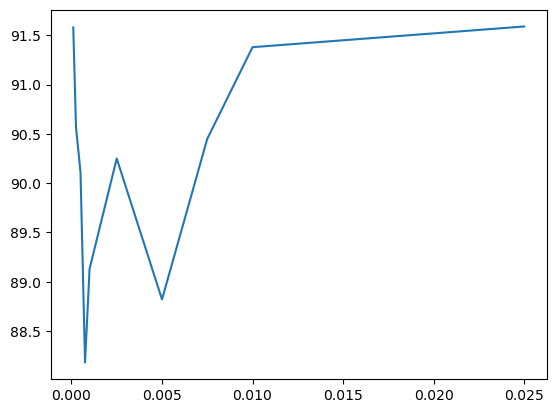

In [18]:
#plot a 2D color map of the results with test_acc_mat_SPSA

# Assuming test_acc_mat_SPSA is a 2D numpy array
# with shape (num_lr, num_epochs)
num_lr = test_acc_mat_SPSA.shape[0]
num_epochs = test_acc_mat_SPSA.shape[1]

# Create a meshgrid for lr_vec and epochs
lr_mesh, epoch_mesh = np.meshgrid(lr_vec, np.arange(num_epochs))

best_acc = np.max(test_acc_mat_SPSA, axis=1)
plt.plot(lr_vec, best_acc)
#

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(test_acc_mat_SPSA[0,:])), y=test_acc_mat_SPSA[0,:], mode='lines', name='PEPG'))
#change theme to white and set the sizer of the plot
fig.update_layout(template='plotly_white', width=400, height=300,margin=dict(l=20, r=20, t=20, b=20))
fig.update_xaxes(title_text="Epochs",type = 'log')
fig.update_yaxes(title_text="Accuracy [%]")

In [20]:
test_acc_SPSA  = test_acc_mat_SPSA[0,:]

In [21]:
np.savetxt('data\\Results\\NN_training\\online_training\\MNIST\\SPSA_test_acc.csv', test_acc_SPSA, delimiter=',')

In [14]:
#use FD to optimize The Neural network
n_epochs =200
NN_MNIST = Tiny_convnet()
N_dim = NN_MNIST.count_parameters()
grad_dim = 1

#specify we don't need the computation graph to keep track of the gradients, we will use SPSA to update the weights
with torch.no_grad():
    for param in NN_MNIST.parameters():
        param.requires_grad = False
loss = nn.CrossEntropyLoss()
# learning parameters

init_pos = NN_MNIST.get_params()

if init_pos.requires_grad:
    # Detach the tensor from the computation graph
    init_pos = init_pos.detach()
if init_pos.is_cuda:
    # Move the tensor to the CPU
    init_pos = init_pos.cpu()
init_pos = init_pos.numpy()

FD_optimizer = FD_opt(init_pos,n_perturb=grad_dim,alpha=1e-3,epsilon=1e-5)
Adam = AdamOptimizer(init_pos, lr=1e-3, beta1=0.9, beta2=0.9, epsilon=1e-8)

test_acc_FD, best_reward_FD = train_online_FD_NN(NN_MNIST,N_dim, n_epochs, train_loader_MNIST, test_loader_MNIST, loss, FD_optimizer,Adam)

Using cuda device
Tiny_convnet(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=784, out_features=10, bias=True)
)
{i+1}Epoch [1/200], Step [100/600], Loss: 2.296044111251831, Test Accuracy: 13.22%
{i+1}Epoch [1/200], Step [200/600], Loss: 2.295804738998413, Test Accuracy: 13.35%
{i+1}Epoch [1/200], Step [300/600], Loss: 2.2956290245056152, Test Accuracy: 13.23%
{i+1}Epoch [1/200], Step [400/600], Loss: 2.295315742492676, Test Accuracy: 13.51%
{i+1}Epoch [1/200], Step [500/600], Loss: 2.295057773590088, Test Accuracy: 13.67%
{i+1}Epoch [1/200], Step [600/600], Loss: 2.2950148582458496, Test Accuracy: 13.68%
{i+1}Epoch [2/200], Step [100/600], Loss: 2.2948684692382812, Test Accuracy: 13.38%

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(test_acc_FD)), y=test_acc_FD, mode='lines', name='PEPG'))
#change theme to white and set the sizer of the plot
fig.update_layout(template='plotly_white', width=400, height=300,margin=dict(l=20, r=20, t=20, b=20))
fig.update_xaxes(title_text="Epochs",type = 'log')
fig.update_yaxes(title_text="Accuracy [%]")

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(test_acc_FD)), y=test_acc_FD, mode='lines', name='PEPG'))
#change theme to white and set the sizer of the plot
fig.update_layout(template='plotly_white', width=400, height=300,margin=dict(l=20, r=20, t=20, b=20))
fig.update_xaxes(title_text="Epochs",type = 'log')
fig.update_yaxes(title_text="Accuracy [%]")

In [11]:
np.savetxt('data\\Results\\NN_training\\online_training\\MNIST\\FD_1_test_acc_MNIST.csv', test_acc_FD, delimiter=',')

In [8]:
np.savetxt('data\\Results\\NN_training\\online_training\\SPSA_test_acc.csv', test_acc_SPSA, delimiter=',')

In [10]:
#Using PSO for training the NN
n_epochs =10
NN_MNIST = Tiny_convnet()
N_dim = NN_MNIST.count_parameters()
pop_size = 200
#specify we don't need the computation graph to keep track of the gradients, we will use CMAES to update the weights
with torch.no_grad():
    for param in NN_MNIST.parameters():
        param.requires_grad = False
loss = nn.CrossEntropyLoss()
# learning parameters

init_pos = NN_MNIST.get_params()

if init_pos.requires_grad:
    # Detach the tensor from the computation graph
    init_pos = init_pos.detach()
if init_pos.is_cuda:
    # Move the tensor to the CPU
    init_pos = init_pos.cpu()
init_pos = init_pos.numpy()

#params dictionary
upper_bound = 0.3
lower_bound = -0.3

params = {'c_1': 2.5, 
          'c_2': 0.85,
          'w': 0.8,
          'Vmax': 0.15*(upper_bound-lower_bound),
          'upper_bound': upper_bound,
          'lower_bound': lower_bound,
          'pop_size' :pop_size,
          }

init_pos = (upper_bound - lower_bound) * np.random.rand(N_dim, pop_size) + lower_bound
V_init = 0.1 * np.random.rand(N_dim, pop_size)
PSO_optimizer = PSO_opt(X_init = init_pos,V_init = V_init,params=params)

test_acc_PSO,best_reward_PSO = train_online_pop_NN(NN_MNIST, n_epochs, train_loader_MNIST, test_loader_MNIST, loss, PSO_optimizer)

Using cuda device
Tiny_convnet(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=784, out_features=10, bias=True)
)
{i+1}Epoch [1/10], Step [50/600], Loss: 2.3209269046783447, Test Accuracy: 15.87%
{i+1}Epoch [1/10], Step [100/600], Loss: 2.1361119747161865, Test Accuracy: 20.8%
{i+1}Epoch [1/10], Step [150/600], Loss: 2.1310675144195557, Test Accuracy: 26.35%
{i+1}Epoch [1/10], Step [200/600], Loss: 1.9755831956863403, Test Accuracy: 32.98%
{i+1}Epoch [1/10], Step [250/600], Loss: 1.853054404258728, Test Accuracy: 28.93%
{i+1}Epoch [1/10], Step [300/600], Loss: 2.098614454269409, Test Accuracy: 22.52%
{i+1}Epoch [1/10], Step [350/600], Loss: 1.920212745666504, Test Accuracy: 29.79%
{i+1}Ep

KeyboardInterrupt: 

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(test_acc_PSO)), y=test_acc_PSO, mode='lines', name='PEPG'))
#change theme to white and set the sizer of the plot
fig.update_layout(template='plotly_white', width=400, height=300,margin=dict(l=20, r=20, t=20, b=20))
fig.update_xaxes(title_text="Epochs",type = 'log')
fig.update_yaxes(title_text="Accuracy [%]")

In [5]:
model = NN_MNIST

# Initialize a list to store the figures
figs = []

# Iterate through each model parameter
for name, param in model.named_parameters():
    if 'weight' in name:  # Filter out only weight parameters
        # Flatten the weights
        weights = param.detach().cpu().numpy().flatten()
        
        # Create a histogram for the weights
        fig = go.Figure()
        fig.add_trace(go.Histogram(x=weights, name=name))
        
        # Update layout to add titles and improve readability
        fig.update_layout(
            title=f'Histogram of Weights for Layer: {name}',
            xaxis_title='Weight values',
            yaxis_title='Frequency',
            bargap=0.2
        )
        
        # Append the figure to the list
        figs.append(fig)

# Show all histograms
for fig in figs:
    fig.show()

In [38]:
#test rastrigin function 
lower_bound = -1
upper_bound = 1
x_1 = np.linspace(lower_bound,upper_bound,300)[:,np.newaxis]
x_2 = np.linspace(lower_bound,upper_bound,300)[:,np.newaxis]

nn_weights = NN_MNIST.get_params().detach().cpu().numpy()[:,np.newaxis]


loss = nn.CrossEntropyLoss()

X_1, X_2 = np.meshgrid(x_1,x_2)

X = np.concatenate([X_1.ravel()[:,np.newaxis] , X_2.ravel()[:,np.newaxis]],axis=1)
F = np.zeros([X.shape[0],1])

(features,labels) = next(iter(train_loader_MNIST))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
features = features.to(device)
labels = labels.to(device)

for i in range(X.shape[0]):
    nn_weights[0:2] = X[i,np.newaxis].T #update the weights
    Y_pred = NN_MNIST.forward_pass_params(nn_weights,features)

    F[i] = loss(Y_pred,labels).detach().cpu().numpy()
    
F_2 = np.reshape(F,[len(x_1),len(x_2)])

#F_2 = np.reshape(np.apply_along_axis(f_rastrigin, 1, X),newshape=[len(x_1),len(x_2)])
# plot using plotly
fig = make_subplots(rows=1, cols=1, subplot_titles=["error ladscape "])

fig.add_trace(go.Contour(z=F_2, x=X_1[0, :], y=X_2[:, 0], colorscale='Turbo', contours_coloring='fill',  # Fill the contours
                                line_width=1.5, showscale=True), row=1, col=1)
fig.update_layout(height = 400,width = 500,  margin=dict(l=20, r=20, t=20, b=20))
fig.show()

[[-1.        ]
 [-1.        ]
 [ 0.2388748 ]
 ...
 [ 0.00176533]
 [ 0.01150962]
 [ 0.0133552 ]]


In [27]:
np.shape( X[i,np.newaxis].T)

(2, 1)